In [1]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np
import cv2
from PIL import Image
from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util import box_ops
import supervision as sv
from copy import deepcopy
import matplotlib.pyplot as plt
import os
import time

os.environ['TORCH_CUDNN_SDPA_ENABLED'] = '1'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
TEXT_PROMPT = "chair. sofa. table. bed."
BOX_THRESHOLD = 0.5
TEXT_THRESHOLD = 0.5

In [2]:

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


In [3]:
def preprocess_image(image):
    """Preprocess image to match model's expected input type"""
    # Convert image to float32 first for better precision during preprocessing
    image = image.astype(np.float32) / 255.0
    # Convert to torch tensor
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
    # Convert to float16 and move to correct device
    return image_tensor.to(device=DEVICE, dtype=torch.float32)


def load_sam_model(checkpoint_path="sam2_h.pth", device="cuda"):
    checkpoint = "/home/s464915/future-designer/experiments/segment-anything-2/checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
    sam = build_sam2(model_cfg, checkpoint)
    sam.to(device=DEVICE)
    predictor = SAM2ImagePredictor(sam)
    return predictor

def apply_coords_torch(
    coords: torch.Tensor, original_size, image_size
) -> torch.Tensor:
    """
    Expects a torch tensor with length 2 in the last dimension. Requires the
    original image size in (H, W) format.
    """
    old_h, old_w = original_size
    new_h, new_w = get_preprocess_shape(
        original_size[0], original_size[1], image_size
    )
    coords = deepcopy(coords).to(torch.float)
    coords[..., 0] = coords[..., 0] * (new_w / old_w)
    coords[..., 1] = coords[..., 1] * (new_h / old_h)
    return coords

def apply_boxes_torch(
    boxes: torch.Tensor, original_size, image_size
) -> torch.Tensor:
    """
    Expects a torch tensor with shape Bx4. Requires the original image
    size in (H, W) format.
    """
    boxes = apply_coords_torch(boxes.reshape(-1, 2, 2), original_size, image_size)
    return boxes.reshape(-1, 4)

def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int):
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def segment_furniture(image_path, grounding_dino_model, predictor):

    # Prepare image for GroundingDINO
    start_time_dino = time.time()
    image_source, gd_image = load_image(image_path)
    
    
    # Get furniture detections
    boxes, logits, phrases = predict(
        model=grounding_dino_model,
        image=gd_image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        device=DEVICE
    )

    end_time_dino = time.time()
    print(f"Time taken by DINO: {end_time_dino - start_time_dino:.2f} seconds")

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_frame)
    plt.axis('off')
    plt.show()

    start_time_sam = time.time()
    # Prepare image for SAM
    image_tensor = preprocess_image(image_source)
    predictor.set_image(image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

    boxes.to(device=DEVICE, dtype=torch.float16)
    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes).to(DEVICE) * torch.tensor([W, H, W, H], dtype=torch.float16, device=DEVICE)

    transformed_boxes = apply_boxes_torch(boxes_xyxy, image_source.shape[:2], image_source.shape[1]).to(DEVICE)

    masks = np.array([])
    for i in range(len(transformed_boxes)):
        mask, scores, _ = predictor.predict(
                point_coords = None,
                point_labels = None,
                box = transformed_boxes[i],
                multimask_output = False,
            )
        
        masks = np.array([mask]) if masks.size == 0 else np.concatenate((masks, [mask]), axis=0)

    end_time_sam = time.time()
    
    print(f"Time taken by SAM: {end_time_sam - start_time_sam:.2f} seconds")
    
    for j in range(len(masks)):
        show_masks(annotated_frame, masks[j], scores)
    
    return masks, scores, transformed_boxes

# Initialize SAM2
sam_model = load_sam_model()
grounding_dino_model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "/home/s464915/future-designer/experiments/GroundingDINO/weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


Time taken by DINO: 0.54 seconds


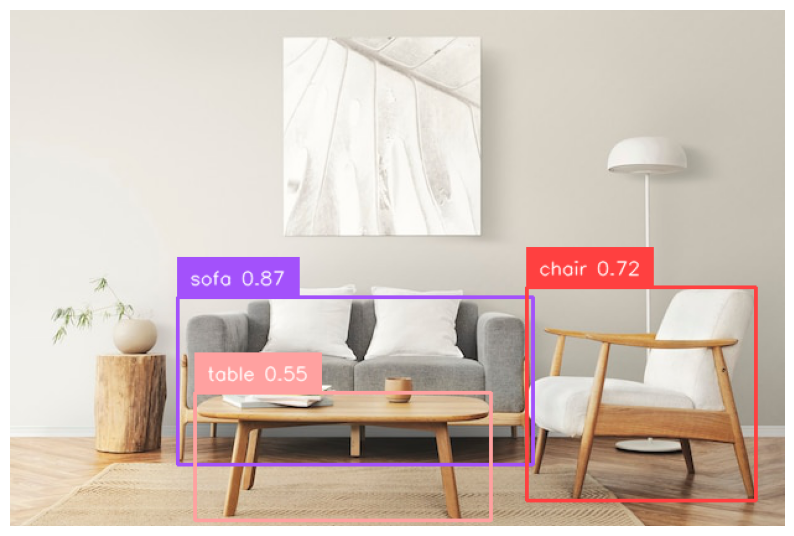

Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).


Time taken by SAM: 0.22 seconds


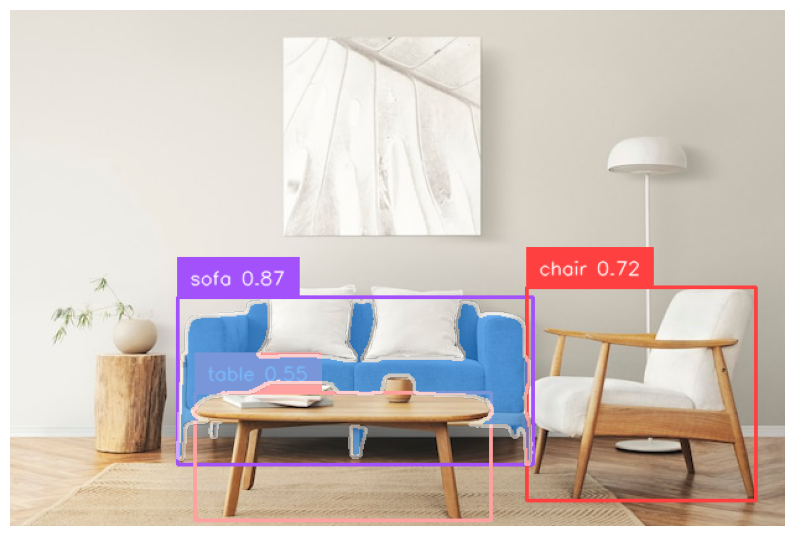

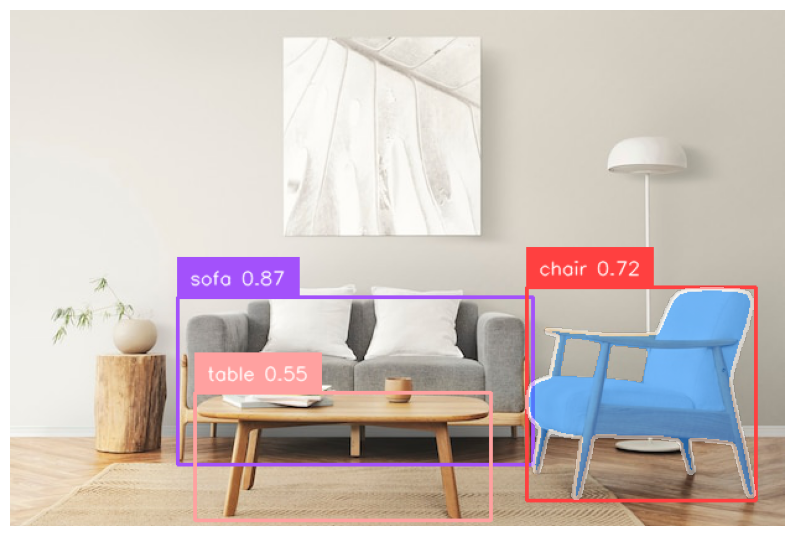

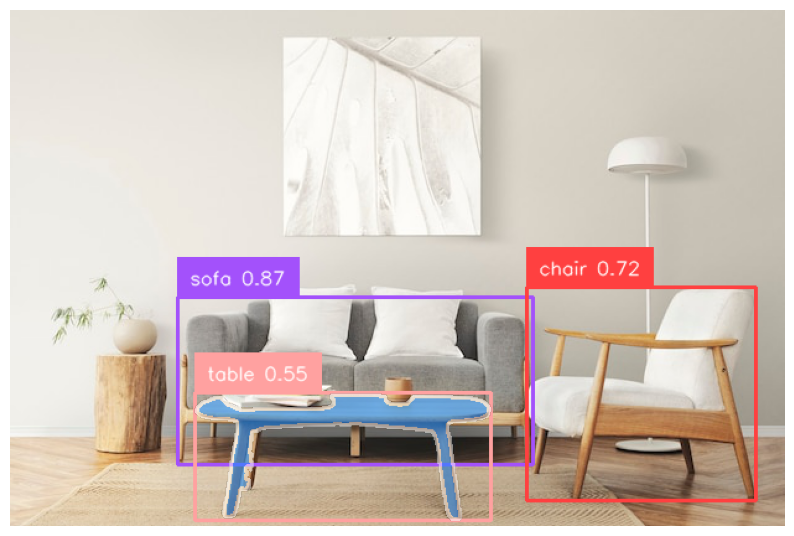

In [4]:
# Process an image
#image_path = "/home/s464915/future-designer/dataset/train/chair/Barrow Leather Armchair_5.jpg"
#image_path = "/home/s464915/future-designer/experiments/photo-1586023492125-27b2c045efd7.jpeg"
image_path = "/home/s464915/future-designer/experiments/chair_sofa.jpg"
masks, scores, boxes = segment_furniture(image_path, grounding_dino_model, sam_model)

(3, 1, 417, 626)


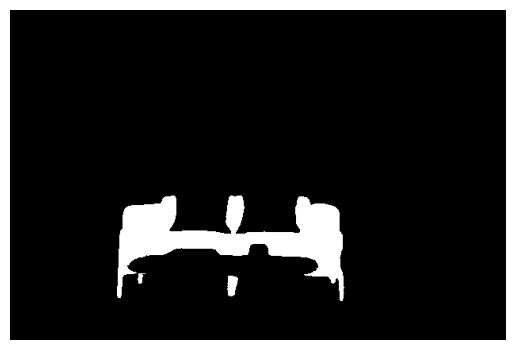

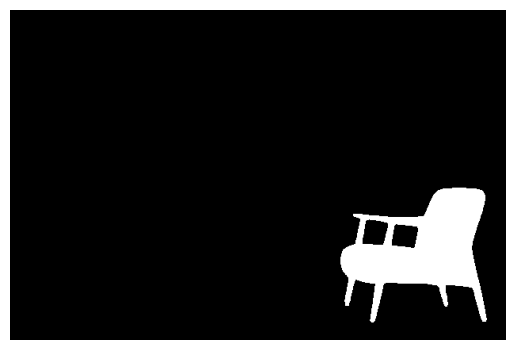

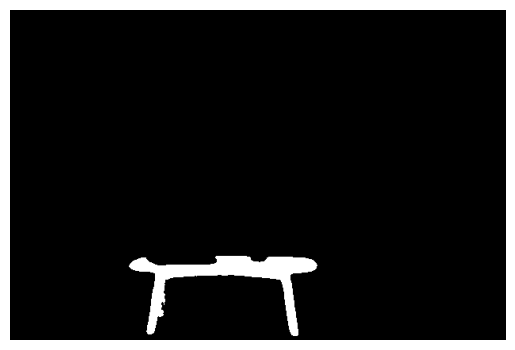

In [ ]:
image_source = cv2.imread(image_path)
image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)

print(masks.shape)

for i in range(len(masks)):
    x0, y0, x1, y1 = boxes[i].int().cpu().numpy()
    mask_slice = masks[i, 0]
    inverted_mask = (1 - mask_slice).astype(np.uint8) * 255  # Convert to 0-255 range
    print(mask_slice.shape)
    plt.imshow(mask_slice, cmap='gray')
    plt.axis('off')
    plt.show()

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{
  "type": "sofa",
  "style": "modern",
  "color": "gray",
  "material": "wood",
  "shape": "L-shaped",
  "size": "medium",
  "details": "woven backrest",
  "pattern": "solid",
  "texture": "smooth"
}
Time taken by Qwen: 2.83 seconds


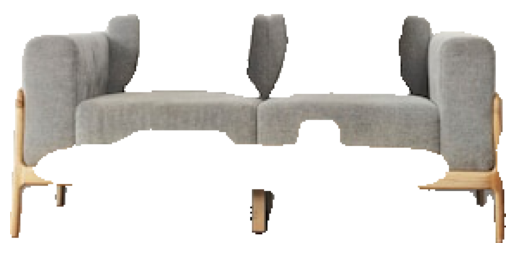

{
  "type": "chair",
  "style": "modern",
  "color": "white",
  "material": "wood",
  "shape": "armchair",
  "size": "medium",
  "details": "woven backrest",
  "pattern": "solid",
  "texture": "smooth"
}
Time taken by Qwen: 2.46 seconds


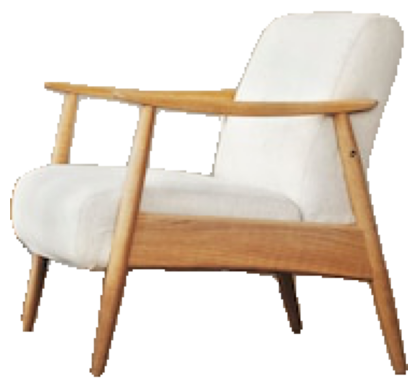

{
  "type": "table",
  "style": "modern",
  "color": "natural",
  "material": "solid wood",
  "shape": "rectangle",
  "size": "medium",
  "details": "smooth surface",
  "pattern": "solid",
  "texture": "smooth"
}
Time taken by Qwen: 2.46 seconds


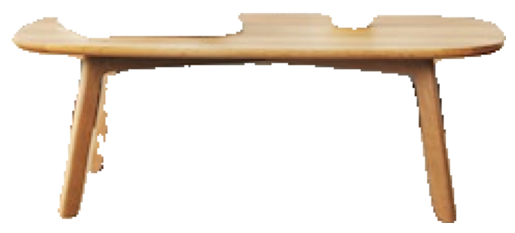

In [6]:
import sys
import json
__file__ = "/home/s464915/future-designer/VLMLabeler/__init__.py"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from VLMLabeler.generator import LabelGenerator

model_name = "qwen2"
model_path = "Qwen/Qwen2-VL-2B-Instruct"

prompt = [
        {
        "role": "system",
        "content": "You are a furniture expert. Analyze the image and provide a detailed description in JSON format."
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text", "text": """Describe the furniture in the image using the following JSON structure. 
                                        Please make sure to use only one word and be really specific, my job depends on it. 
                                        If any field is not applicable or cannot be determined, use "N/A".
                    {
                        "type": "main furniture type (only: bed, chair, table, sofa)",
                        "style": "overall style",
                        "color": "main color",
                        "material": "primary material",
                        "shape": "general shape",
                        "size": "size category (e.g., small, medium, large)",
                        "details": "any decorative features",
                        "pattern": "surface pattern (e.g., solid, striped, floral)",
                        "texture": "surface texture (e.g., smooth, rough, woven)"
                    }
            """},
        ],
    }
]

generator = LabelGenerator(model_name, model_path, prompt)

for i in range(len(masks)):
    x0, y0, x1, y1 = boxes[i].int().cpu().numpy()
    mask_slice = masks[i, 0, y0:y1, x0:x1]
    inverted_mask = (1 - mask_slice).astype(np.uint8) * 255  # Convert to 0-255 range

    # Create a white canvas with the same shape as the ROI
    roi = image_source[y0:y1, x0:x1]
    white_bg = np.ones_like(roi, dtype=np.uint8) * 255

    # Fill the mask region with the original image
    mask_slice = cv2.bitwise_or(
        cv2.bitwise_and(roi, roi, mask=255 - inverted_mask),
        cv2.bitwise_and(white_bg, white_bg, mask=inverted_mask)
    )
    mask_slice = Image.fromarray(mask_slice)
    label, time = generator(mask_slice)

    print(json.dumps(label, indent=2))
    print(f"Time taken by Qwen: {time:.2f} seconds")

    mask_slice.save(f"mask_{i}.png")
    plt.imshow(mask_slice, cmap='gray')
    plt.axis('off')
    plt.show()